Research paper used:
https://arxiv.org/pdf/1609.03499.pdf

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42); # for reproducibility

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(".".join(words))))
stoi = {c:i for i,c in enumerate(chars)}
itos = {c:i for i,c in stoi.items()}
vocab_size = len(chars)

In [3]:
# preparing the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [4]:
# validate the dataset
for x,y in zip(Xtr[:20],Ytr[:20]):
  print(''.join([itos[i.item()] for i in x]), '-->' ,itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [43]:
# Need 3 methods, init (obviously), call and parameters (to set we 'need grads')

# -----------------------------------------------------------------------------------------------
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  def __init__(self, dim, momentum=0.1, eps=1e-5):
    self.training = True
    self.eps = eps
    self.momentum = momentum
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True)
      xvar = x.var(dim, unbiased=True, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    dx = (x - xmean)/torch.sqrt(xvar + self.eps)
    self.out = self.gamma * dx + self.beta

    if self.training:
      with torch.no_grad():
        self.running_mean = (1.0 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1.0 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, idx):
    self.out = self.weight[idx]
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class Flatten: # this matches pytorch's nn.Flatten API
  def __call__(self, x):
    self.out = x.view(x.size(0), -1)
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive: # this is better!
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out

  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [91]:
# Boiler plate of model initialization
# model = Sequential([
#   Embedding(), # embedding
#   Flatten(), Linear(), BatchNorm1d(), Tanh(), # flat -> input -> batchnorm -> nonlinearity
#   Linear(), # output layer
# ])


# Initialize the model
emb_sz = 24
n_hidden = 100

model = Sequential([
  Embedding(vocab_size, emb_sz), # B, S, C
  FlattenConsecutive(2), Linear(emb_sz  *2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size)
])

parameters = model.parameters()
print(sum([p.nelement() for p in parameters]))
for p in parameters:
  p.requires_grad = True

48775


In [94]:
bs = 32
epoch = 200000
losses = []

for i in range(epoch):
  # mini batch
  idx = torch.randint(0, len(Xtr), (bs,))
  Xbs, Ybs = Xtr[idx], Ytr[idx]

  # forward
  logits = model(Xbs)
  loss = F.cross_entropy(logits, Ybs)

  # backward
  for p in parameters:
    p.grad = None
  loss.backward()

  # step
  lr = 0.01 if i < 100000 else 0.001
  for p in parameters:
    p.data -= lr * p.grad

  # track
  perp = torch.exp(loss)
  losses.append(loss.log10().item())
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{epoch:7d}: {loss.item():7.4f} | {perp.item():7.4f}')

      0/ 200000:  2.2583 |  9.5669
  10000/ 200000:  2.1489 |  8.5755
  20000/ 200000:  1.8733 |  6.5099
  30000/ 200000:  2.6845 | 14.6502
  40000/ 200000:  2.1906 |  8.9407
  50000/ 200000:  2.0389 |  7.6822
  60000/ 200000:  1.8903 |  6.6211
  70000/ 200000:  2.2178 |  9.1872
  80000/ 200000:  1.6950 |  5.4465
  90000/ 200000:  1.9959 |  7.3586
 100000/ 200000:  1.9999 |  7.3880
 110000/ 200000:  1.9641 |  7.1287
 120000/ 200000:  1.9402 |  6.9604
 130000/ 200000:  1.7308 |  5.6453
 140000/ 200000:  1.8876 |  6.6038
 150000/ 200000:  1.7886 |  5.9810
 160000/ 200000:  1.8135 |  6.1317
 170000/ 200000:  1.7101 |  5.5295
 180000/ 200000:  2.2178 |  9.1868
 190000/ 200000:  2.1683 |  8.7431


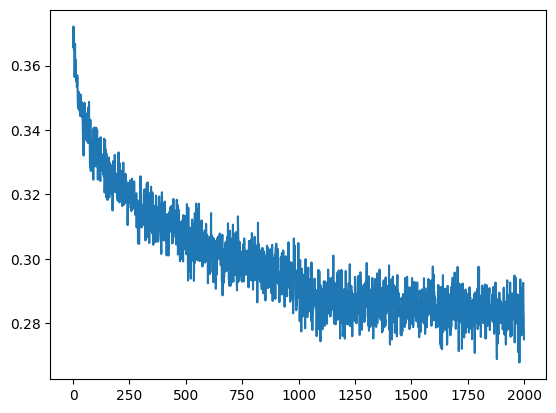

In [95]:
# plot loss
plt.plot(torch.tensor(losses).view(-1, 100).mean(1));

In [96]:
# cal split loss
for layer in model.layers:
  layer.training = False

@torch.no_grad() # this decorator disables gradient tracking inside pytorch
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9067895412445068
val 2.009490966796875


In [97]:
# sample from the model
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

swaina.
lendon.
jouyncie.
tyniab.
jossain.
edem.
joian.
tayton.
vikushi.
whittne.
inilan.
mollion.
anan.
massidus.
cishton.
kidy.
aydel.
shriya.
elianny.
clasym.
